In [1]:
# Env
import os
from dotenv import load_dotenv
if not load_dotenv() or 'HOPSWORKS_API_KEY' not in os.environ:
    print("Please provide a .env file add HOPSWORKS_API_KEY to it.")
    exit(1)

import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201877
Connected. Call `.close()` to terminate connection gracefully.


In [16]:
from hsfs import feature_view as hsfs_feature_view
from hsfs import constructor as hsfs_constructor

# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
iris_fg = fs.get_feature_group(name="iris", version=1)
query: hsfs_constructor.query.Query = iris_fg.select_all()
feature_view: hsfs_feature_view.FeatureView = fs.get_or_create_feature_view(name="iris",
                                  version=1,
                                  description="Read from Iris flower dataset",
                                  labels=["variety"],
                                  query=query)

In [9]:
feature_view.features

[Training Dataset Feature('sepal_length', 'double', 0, False, None, None, 208243),
 Training Dataset Feature('sepal_width', 'double', 1, False, None, None, 208243),
 Training Dataset Feature('petal_length', 'double', 2, False, None, None, 208243),
 Training Dataset Feature('petal_width', 'double', 3, False, None, None, 208243),
 Training Dataset Feature('variety', 'string', 4, True, None, None, 208243)]

In [10]:
feature_view.description

'Read from Iris flower dataset'

In [11]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
model = KNeighborsClassifier(n_neighbors=2)
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (0.69s) 


KNeighborsClassifier(n_neighbors=2)

In [12]:
X_train

,sepal_length,sepal_width,petal_length,petal_width
0,5.700000,3.800000,1.700000,0.300000
3,6.000000,2.900000,4.500000,1.500000
4,5.000000,3.000000,1.600000,0.200000
5,6.400000,2.900000,4.300000,1.300000
6,7.200000,3.000000,5.800000,1.600000
...,...,...,...,...
150,4.920533,2.559524,1.920897,0.656094
151,4.625774,2.889183,5.115435,1.472565
152,5.748708,2.849190,6.548023,2.355877
153,6.213147,2.339865,3.192052,1.045546


In [13]:
y_train

,variety
0,Setosa
3,Versicolor
4,Setosa
5,Versicolor
6,Virginica
...,...
150,Setosa
151,Versicolor
152,Virginica
153,Versicolor


In [19]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

In [20]:
metrics

{'Setosa': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9},
 'Versicolor': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 14},
 'Virginica': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 31},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 31}}

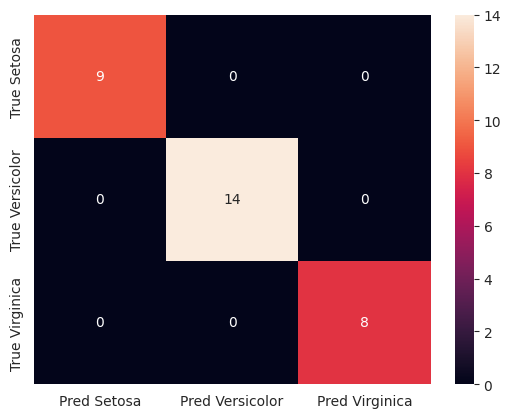

In [23]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['True Setosa', 'True Versicolor', 'True Virginica'],
                     ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [22]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="iris_model"
if not os.path.isdir(model_dir):
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/iris_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="iris_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Iris Flower Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/201877/models/iris_model/1


Model(name: 'iris_model', version: 1)